# Exercises

## Exercise 1 - simulating place cells
---
Use the code we build to simulate place cells in the lesson.

A - Explore what happens when you change the binning in the definition of the firing rate maps (`space_bins`). Make it coarser or broader. 

In [1]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import seaborn as sns
import pickle
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})


In [3]:
# Download lesson data
download_data('https://surfdrive.surf.nl/files/index.php/s/z7mMiznEWOT0Iak')

#import data
with open('data/psth_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

spike_times = data['spike_times']
stim_onsets = data['stim_onsets']
stim_type = data['stim_type']
stim_duration = data['stim_duration']

In [4]:
# cut and align to stimulus presentation
psth_onset = -0.5
psth_offset = stim_duration+0.5


aligned_spikes_stim1 = []
stim1_onsets = stim_onsets[stim_type==1]

for cell_spikes in spike_times:
    aligned_spikes = []
    for stim_onset in stim1_onsets:
        onset = stim_onset + psth_onset
        offset = stim_onset +psth_offset
        # take only spikes during stimulus, aligned to stimulus onset
        stim_spikes = [spike-stim_onset for spike in cell_spikes if (spike>=onset and spike<offset)]
        aligned_spikes.append(stim_spikes)

    aligned_spikes_stim1.append(aligned_spikes)

aligned_spikes_stim2 = []
stim1_onsets = stim_onsets[stim_type==2]

for cell_spikes in spike_times:
    aligned_spikes = []
    for stim_onset in stim1_onsets:
        onset = stim_onset + psth_onset
        offset = stim_onset +psth_offset
        # take only spikes during stimulus, aligned to stimulus onset
        stim_spikes = [spike-stim_onset for spike in cell_spikes if (spike>=onset and spike<offset)]
        aligned_spikes.append(stim_spikes)

    aligned_spikes_stim2.append(aligned_spikes)

In [5]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length 
# the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) 
# the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) 
# the peak firing rate for each cell, drawn from an exponential distribution

In [6]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

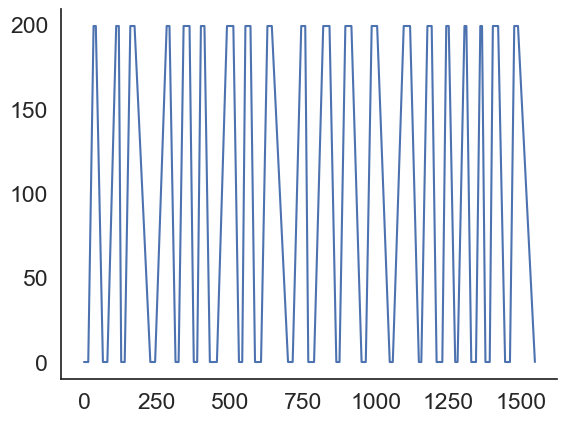

In [33]:
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps

plt.plot(t,x)

In [8]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

100%|█████████████████████████████████████████| 100/100 [00:20<00:00,  4.99it/s]


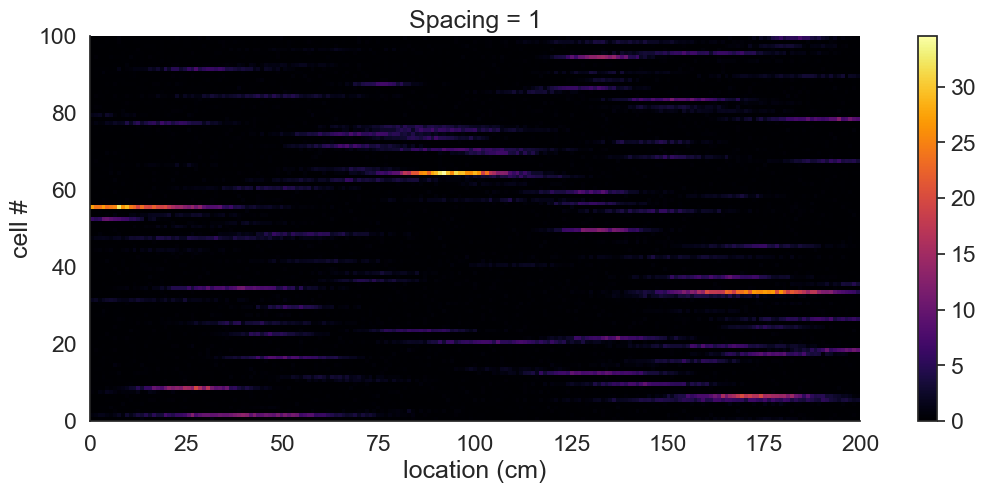

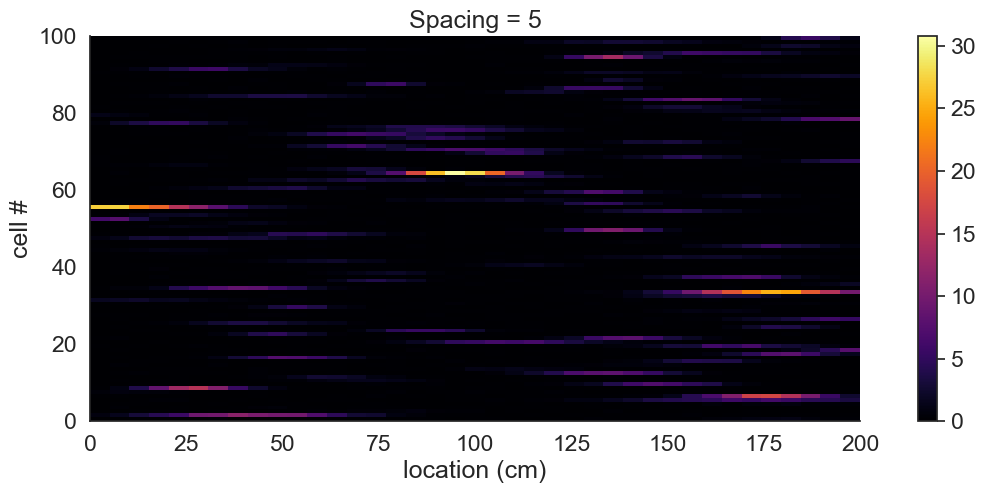

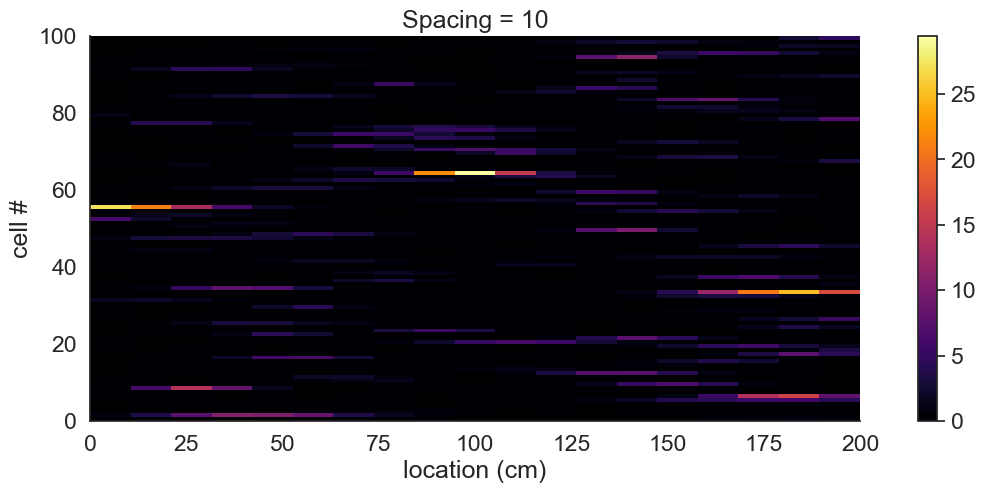

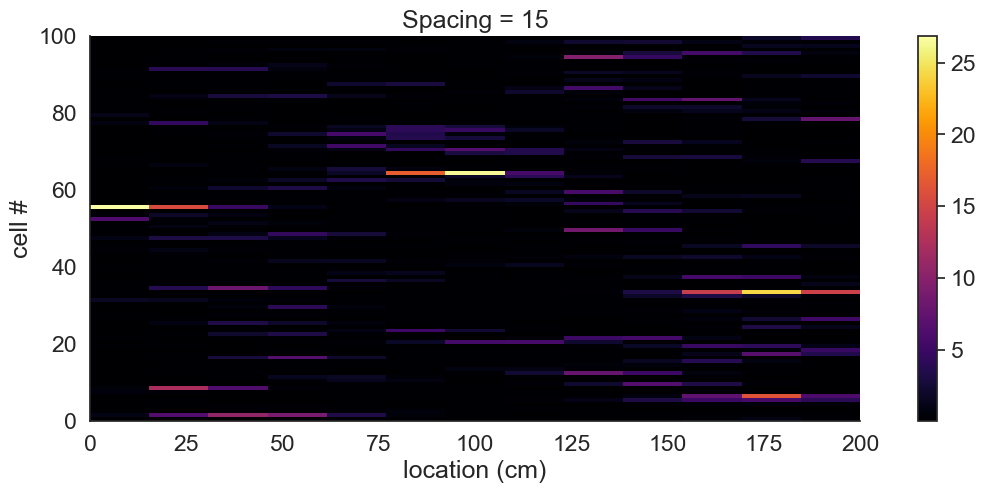

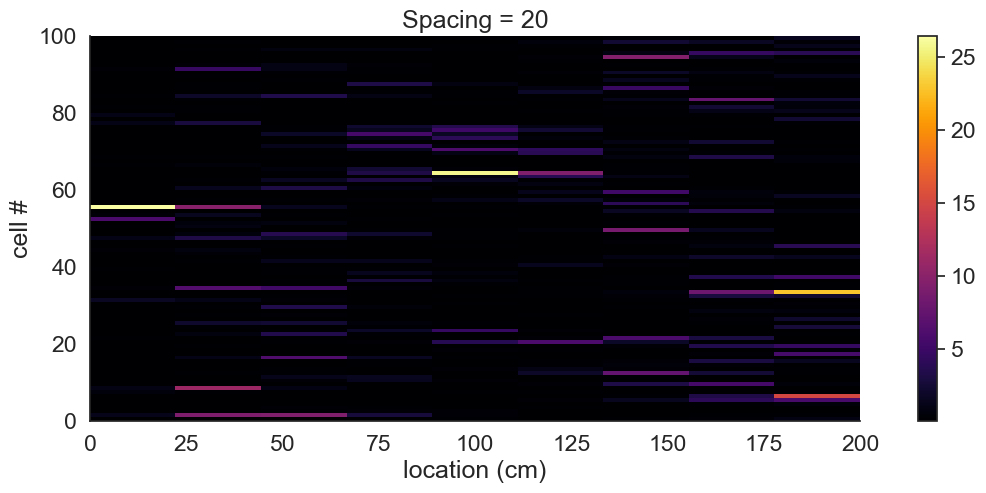

In [24]:
space = [1,5,10,15,20]
spike_positions = [np.interp(s, t, x) for s in spikes]

def plot_bins(space):
    space_bins = np.arange(0., 200., space)
    
    # we compute histograms for eaxh cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    
    # put them together into a matrix of floating point numbers (for plotting)
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    
    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps
    
    firing_rate_maps = spikes_hist / occupancy 

    plt.figure(figsize=(15,5))
    plt.title("Spacing = "+str(space))
    plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    plt.colorbar()

for sp in space:
    plot_bins(sp)

As one could expect, we observe a 'flatter' distribution with broader bins. for very small bins (size 1) we observe a varying intensity and a fine grained structure of the receptive fields.


B - In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.

I'm not 100% sure what is meant with the question 'which variable determines the noise level'', since in the simulation we just add the noise to the firing rate, which would be the variable. In real life the noise level can always arise through the measurement itself or it could be thermal noise.

100%|█████████████████████████████████████████| 100/100 [00:19<00:00,  5.06it/s]


0.01


100%|█████████████████████████████████████████| 100/100 [00:19<00:00,  5.00it/s]


0.5


100%|█████████████████████████████████████████| 100/100 [00:19<00:00,  5.01it/s]


1


100%|█████████████████████████████████████████| 100/100 [00:20<00:00,  4.96it/s]


5


100%|█████████████████████████████████████████| 100/100 [00:20<00:00,  4.95it/s]


10


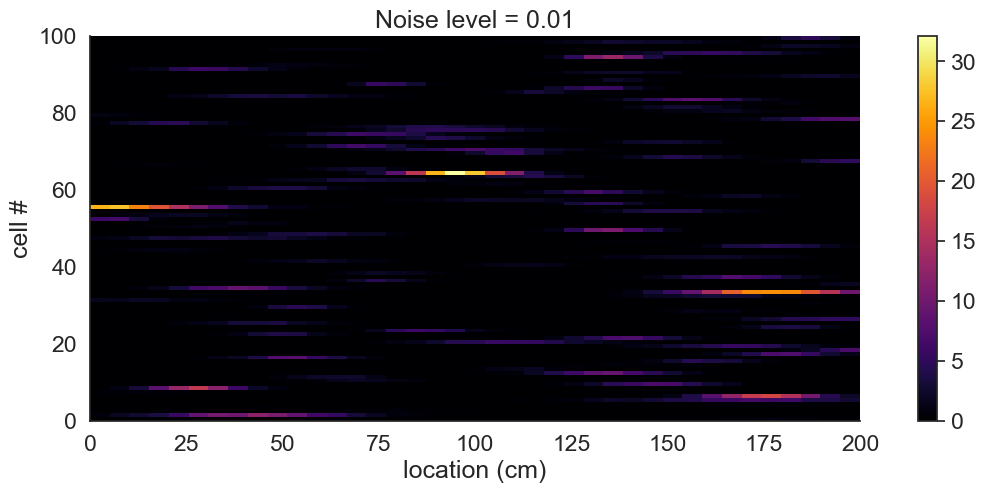

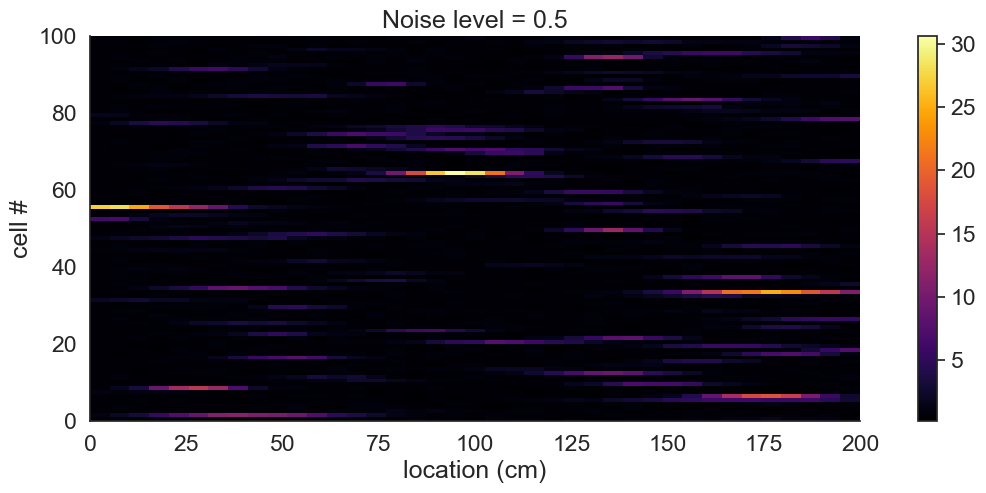

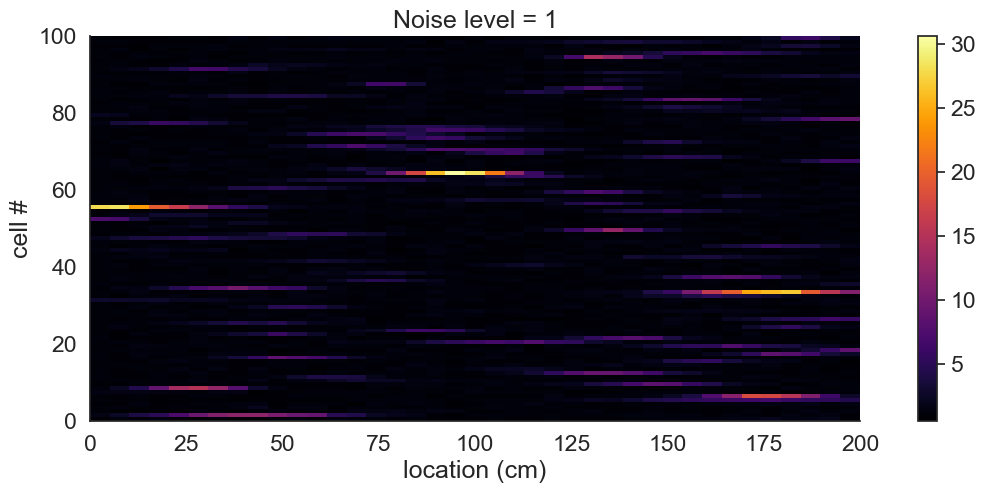

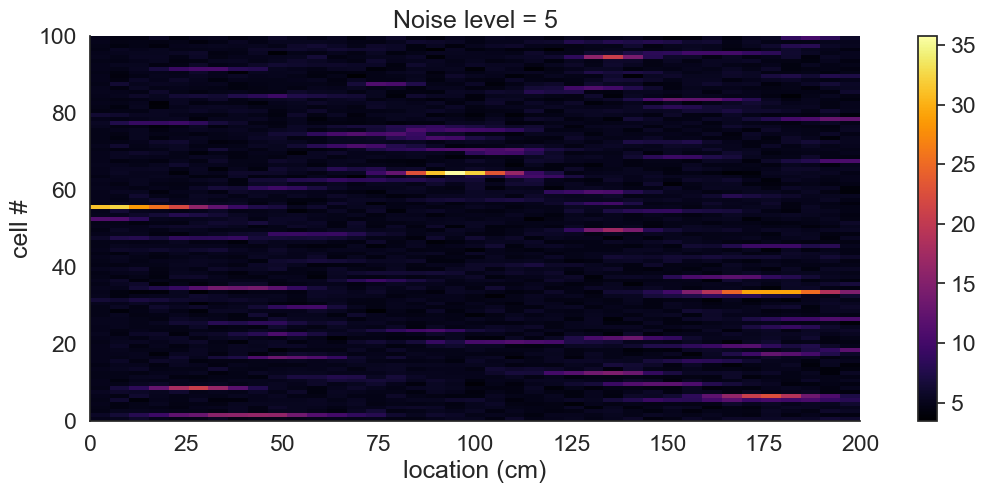

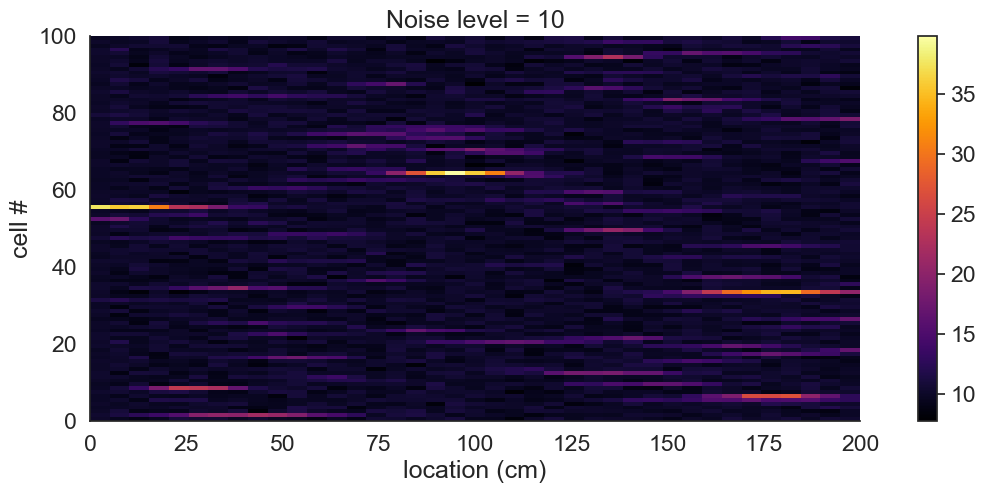

In [19]:
noises = [0.01,0.5,1,5,10]

def vary_noise(noise):
    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    #noise = 0.1 # the baseline noise firing rate
    spikes = []
    
    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)

    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., 200., 5)
    
    # we compute histograms for eaxh cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    
    # put them together into a matrix of floating point numbers (for plotting)
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    
    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps
    
    firing_rate_maps = spikes_hist / occupancy 

    plt.figure(figsize=(15,5))
    plt.title("Noise level = "+str(noise))
    plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    plt.colorbar()

for n in noises:
    vary_noise(n)
    print(n)

With more noise we see overall more actuation of the neurons. The overall amplitude also increases naturally since we add large numbers to our firing rates.
To discriminate smaller values (here the noise) we could scale our plots logarithmically.

C - We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes. 

In [18]:
from scipy.stats import gaussian_kde

In [23]:
np.shape(firing_rate_maps)

(100, 199)

100%|█████████████████████████████████████████| 100/100 [00:20<00:00,  4.94it/s]


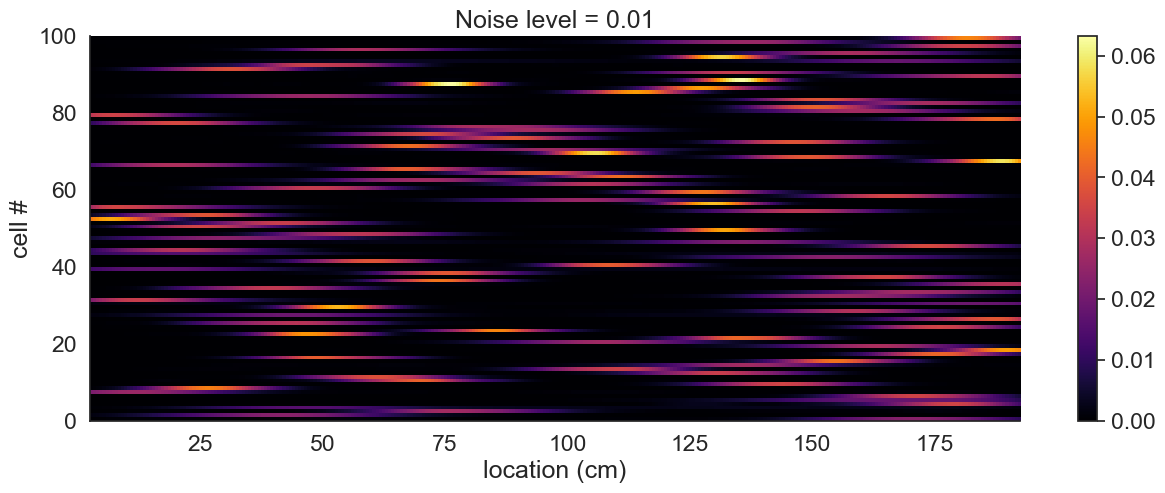

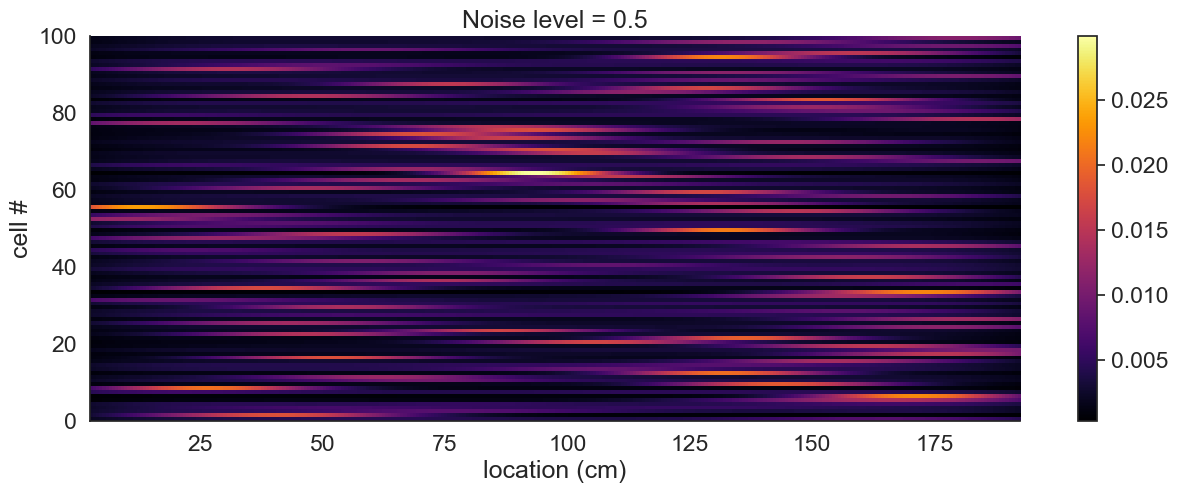

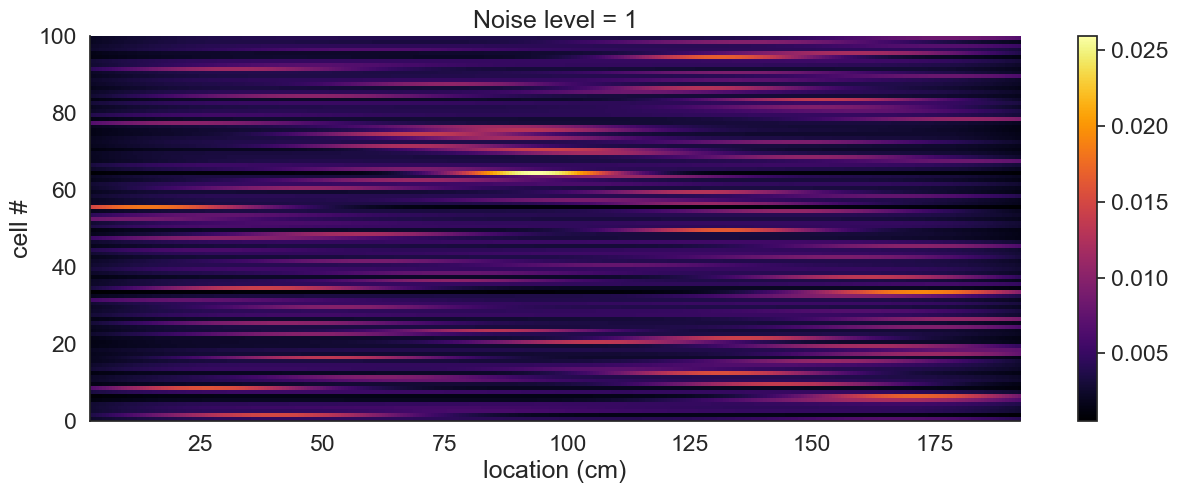

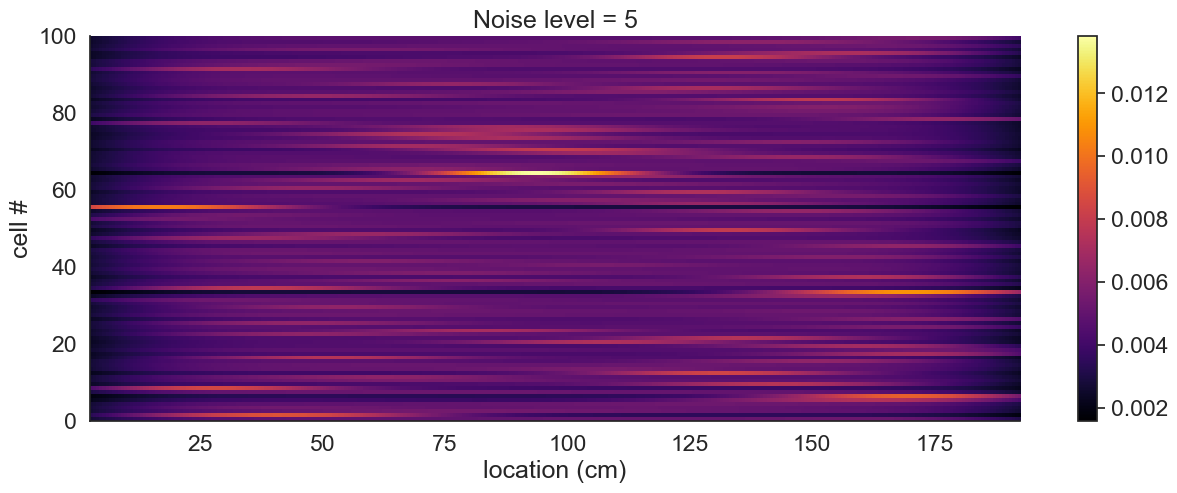

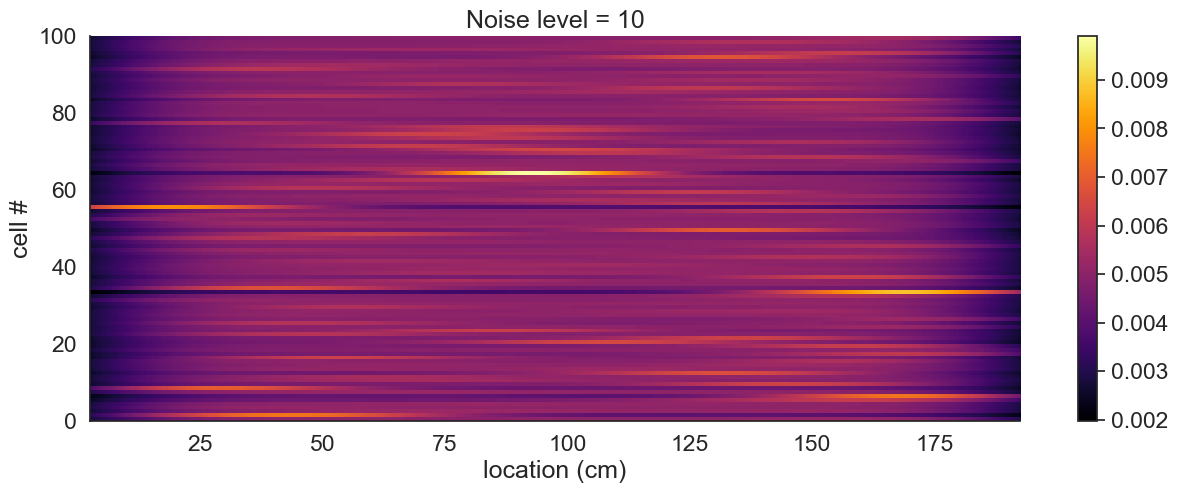

In [25]:
noises = [0.01,0.5,1,5,10]

def vary_noise_smooth(noise):
    sampling_rate = 10000.
    t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
    x_sampling = np.floor(np.interp(t_sampling, t, x))
    #noise = 0.1 # the baseline noise firing rate
    spikes = []
    
    for i in tqdm(range(n_cells)):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp)

    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., 200., 5)
    
    # we compute histograms for eaxh cell
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    
    # put them together into a matrix of floating point numbers (for plotting)
    spikes_hist = np.vstack(spikes_hist).astype(np.float64)
    
    # we also need an "occupancy histogram" in order to normalize the firing rates maps 
    occupancy = np.histogram(x, space_bins)[0] /  fps
    
    firing_rate_maps = spikes_hist / occupancy 

    x_space = (space_bins[:-1] + space_bins[1:]) / 2  
    x_smooth = np.linspace(x_space[0], x_space[-1], 300)  
    
    firing_rate_maps_kde = []
    
    for row in firing_rate_maps:

        kde = gaussian_kde(x_space, weights=row, bw_method=0.3) 
        smoothed = kde(x_smooth)
        firing_rate_maps_kde.append(smoothed)
    
    firing_rate_maps_kde = np.vstack(firing_rate_maps_kde)

    plt.figure(figsize=(15, 5))
    plt.title("Noise level = " + str(noise))
    plt.imshow(firing_rate_maps_kde, cmap='inferno', extent=[x_smooth[0], x_smooth[-1], 0, n_cells], aspect='auto')
    plt.xlabel('location (cm)')
    plt.ylabel('cell #')
    plt.colorbar()

for n in noises:
    vary_noise_smooth(n)
    

For high noise levels the smoothing produces a very blurry picture with a lot of actuation.On the other hand, it makes the few strong signals very visible and ever weaker ones are now clearly visible. For small noise amplitudes the individual cells are very well visible.

D - When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation 

$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$ 

where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?) 

In [82]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 10 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

100%|█████████████████████████████████████████| 100/100 [00:19<00:00,  5.03it/s]


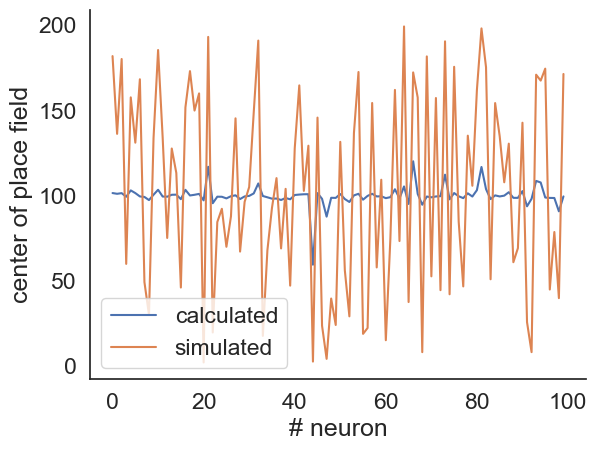

In [83]:
mean = []
for i in range(len(spikes)):
    y_values = np.interp(spikes[i], t, x) 

    m = np.mean(y_values)
    mean.append(m)
    
neurons = np.arange(100)
plt.plot(neurons,mean, label = "calculated")
plt.plot(neurons,pf_centers, label = "simulated")
plt.xlabel('# neuron')
plt.ylabel("center of place field")
plt.legend()

We observe a big variance in the calculated values and the simulated centers. I'm not sure why. I maybe read the arrays wrong.

## Exercise 2 - mutual information
---
A - Implement the mutual information formula discussed in the lesson, and apply it to the place cell data we simulated.

B - Adapt the simulation so that you can systematically vary 1) Peak firing rate, 2) place cell size 3) baseline noise. 
Study how mutual information vary with these parameters. Use both definition of mutual information above, and discuss the differences between them. Make some plots to show how the dependency goes.

## Exercise 3 - working with real data
---
Load the data from `linear_track_data.pickle`. It contains neural recordings from a mouse running on a linear track.
- `x` contains the position of the animal
- `t` contains the corresponding times, in seconds
- `spikes` contains a list of lists. Each list contains the timestamps of the spikes emitted by a neuron.

A - Visualiaze the position a s a function of time. Plot the spike of a selected cell in space.

B - Calculate the firing rate maps for all the cells, and plot them sorted by increasing peak positon.

C - Calculate the spatial information for each cell, and plot the distribution. Plot the firing rate maps of the 5 cells with lower spatial information, and the firing rate maps of the 5 cells with higher spatial information. Comment on the differences.